# Dataset

The dataset used is a set of tweets with keywords, locations, and labels whether the tweet is a disaster or not. I got this dataset from a friend of mine which I will put into use for NLP task using BERT model.

<img src="Project_Image.png">

# Importing Libraries & Reading Dataset

The libraries used will be mostly available if you haven't install it, unless for the my personal library (cex) that is used for various data science task. You can check more about it in <a href="https://github.com/johnw1llliam/CEX">here</a>.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import html
from spellchecker import SpellChecker
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
import shutil
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

tf.get_logger().setLevel('ERROR')
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

import cex

C:\Users\OMEN\miniconda3\envs\tf\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\OMEN\miniconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
C:\Users\OMEN\miniconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


C:\Users\OMEN\miniconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\OMEN\miniconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want

In [2]:
df = pd.read_csv("tweets.csv")

# EDA

From the head of the data below, we can see that there are already NaNs and there are 5 columns available and the target column is encoded already.

In [3]:
df.head()

,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0


We have 11370 rows and 5 columns for the dataset where 2 of them are int64 and 3 of them are object. We won't use the id column so we will drop it later.

In [4]:
cex.explore(df)

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

Dimension: 11370 x 5

object: 3 columns
int64: 2 columns


From a glimpse below, we might going to use the keyword column since it has potential impact for the target

In [5]:
counts = df.groupby(['keyword', 'target']).size().unstack(fill_value=0)
print(counts)

target                0   1
keyword                    
ablaze               14  20
accident             21  12
aftershock           33  16
airplane%20accident  52  22
ambulance            29   6
...                  ..  ..
wounded              25  19
wounds               44   3
wreck                55  10
wreckage             23  10
wrecked              34   6

[219 rows x 2 columns]


The target column is unbalanced by 1:4, however BERT model should be able to handle this level of imbalance

In [6]:
target_counts = df['target'].value_counts()
target_counts

target
0    9256
1    2114
Name: count, dtype: int64

The nulls are located inside the location column which consist 30% of all columns

In [7]:
cex.null_check_text(df)

id: 0 (0.0%)
keyword: 0 (0.0%)
location: 3418 (30.06156552330695%)
text: 0 (0.0%)
target: 0 (0.0%)

Total missing values: 3418 (6.01231310466139%)



## Data Cleaning

Fill the NaN in location with Unknown

In [8]:
df["location"] = df["location"].fillna("Unknown")

In [9]:
cex.null_check_text(df)

id: 0 (0.0%)
keyword: 0 (0.0%)
location: 0 (0.0%)
text: 0 (0.0%)
target: 0 (0.0%)

Total missing values: 0 (0.0%)



Fix typos using SpellChecker library

In [10]:
spell = SpellChecker()

def spellcheck_text(text):
    words = text.split()
    corrected_words = [spell.correction(word) if spell.correction(word) is not None else word for word in words]
    corrected_text = " ".join(corrected_words)
    return corrected_text

df['keyword'] = df['keyword'].apply(spellcheck_text)
df['location'] = df['location'].apply(spellcheck_text)
df['text'] = df['text'].apply(spellcheck_text)

df.head()

,id,keyword,location,text,target
0,0,ablaze,Unknown,Communal violence in chainsaw Telangana. stone...,1
1,1,ablaze,Unknown,Telangana: Section 144 has been imposed in bra...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, we",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,Unknown,lord jesus your love brings freedom and pardon...,0


Drop unused columns

In [11]:
df = cex.delete_column(df, ["id"])

Finally we will split the data:

<ul>
    <li> Training (70%) </li>
    <li> Validation (20%) </li>
    <li> Testing (10%) </li>
</ul>

In [12]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=4, stratify=df["target"])
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=4, stratify=df_train["target"])

print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(8186, 4)
(1137, 4)
(2047, 4)


# Modelling

First we will prepare the data for training, testing, and validation.

In [13]:
X_train = df_train["location"] + " SEP " + df_train["keyword"] + " SEP " + df_train["text"]
X_val = df_val["location"] + " SEP " + df_val["keyword"] + " SEP " + df_val["text"]
X_test = df_test["location"] + " SEP " + df_test["keyword"] + " SEP " + df_test["text"]
y_train = df_train.copy()["target"]
y_val = df_val.copy()["target"]
y_test = df_test["target"]

The model used will be small bert uncased (due to computing power issue, I prefer this). We will prepare the model.

In [14]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [15]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

Build the model architecture below, here I used Dense with Dropout layer to avoid overfitting. The output layer will be fitted with sigmoid activation function with 2 classes output.

In [16]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dense(128)(net)
  net = tf.keras.layers.Dense(128)(net)
  net = tf.keras.layers.Dropout(0.5)(net)
  net = tf.keras.layers.Dense(2, activation="sigmoid", name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [17]:
classifier_model = build_classifier_model()

In [18]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metrics = tf.metrics.SparseCategoricalAccuracy()

We can set the epochs and learning rate for the model in here.

In [19]:
epochs = 20
steps_per_epoch = len(df_train)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 0.00001
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw'
                                          )

In [20]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

Training the model

In [21]:
print(f'Training model with {tfhub_handle_encoder}')

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1


In [22]:
history = classifier_model.fit(x=X_train,
                               y=y_train,
                               validation_data=(X_val,y_val),
                               epochs=epochs)

Epoch 1/20
256/256 [==============================] - 58s 211ms/step - loss: 0.9285 - sparse_categorical_accuracy: 0.5195 - val_loss: 0.5788 - val_sparse_categorical_accuracy: 0.7093
Epoch 2/20
256/256 [==============================] - 54s 211ms/step - loss: 0.6631 - sparse_categorical_accuracy: 0.6893 - val_loss: 0.4754 - val_sparse_categorical_accuracy: 0.8119
Epoch 3/20
256/256 [==============================] - 54s 212ms/step - loss: 0.5562 - sparse_categorical_accuracy: 0.7707 - val_loss: 0.4140 - val_sparse_categorical_accuracy: 0.8241
Epoch 4/20
256/256 [==============================] - 54s 212ms/step - loss: 0.4954 - sparse_categorical_accuracy: 0.7951 - val_loss: 0.3612 - val_sparse_categorical_accuracy: 0.8412
Epoch 5/20
256/256 [==============================] - 56s 218ms/step - loss: 0.4461 - sparse_categorical_accuracy: 0.8142 - val_loss: 0.3259 - val_sparse_categorical_accuracy: 0.8666
Epoch 6/20
256/256 [==============================] - 57s 221ms/step - loss: 0.3944 -

# Evaluation

Creating the prediction result for the classification report and the confusion matrix.

In [23]:
y_pred = classifier_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

36/36 [==============================] - 4s 87ms/step


dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


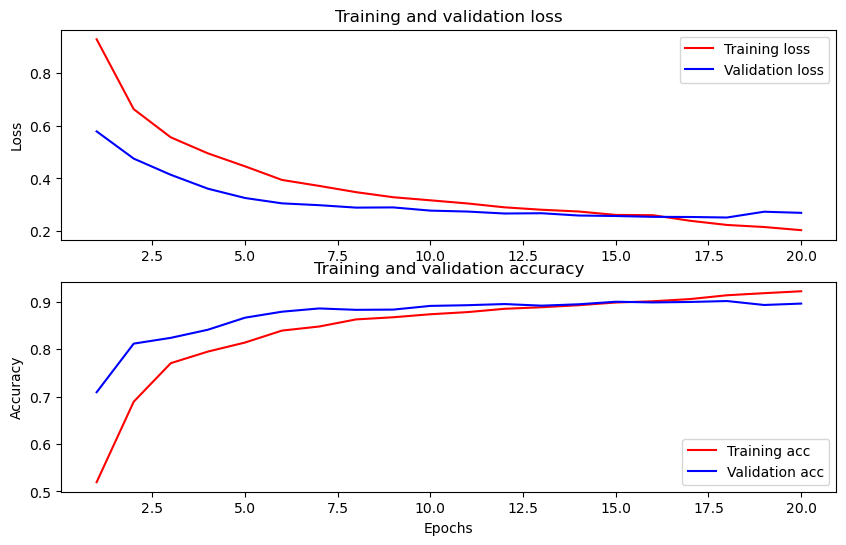

In [24]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['sparse_categorical_accuracy']
val_acc = history_dict['val_sparse_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [25]:
print(classification_report(y_test, y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       926
           1       0.67      0.80      0.73       211

    accuracy                           0.89      1137
   macro avg       0.81      0.85      0.83      1137
weighted avg       0.90      0.89      0.89      1137



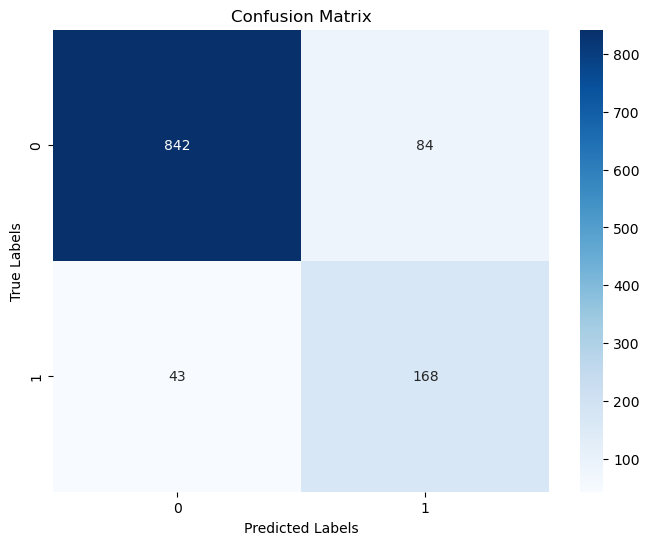

In [26]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()